In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
from corner_detector import *
from anms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
filename = 'small-right.jpg'
img=cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)


5860


In [75]:
x,y,rmax=anms(c, 1000)

(-68.83437500000001, 1400.834375, 1051.2210264900664, -0.5)

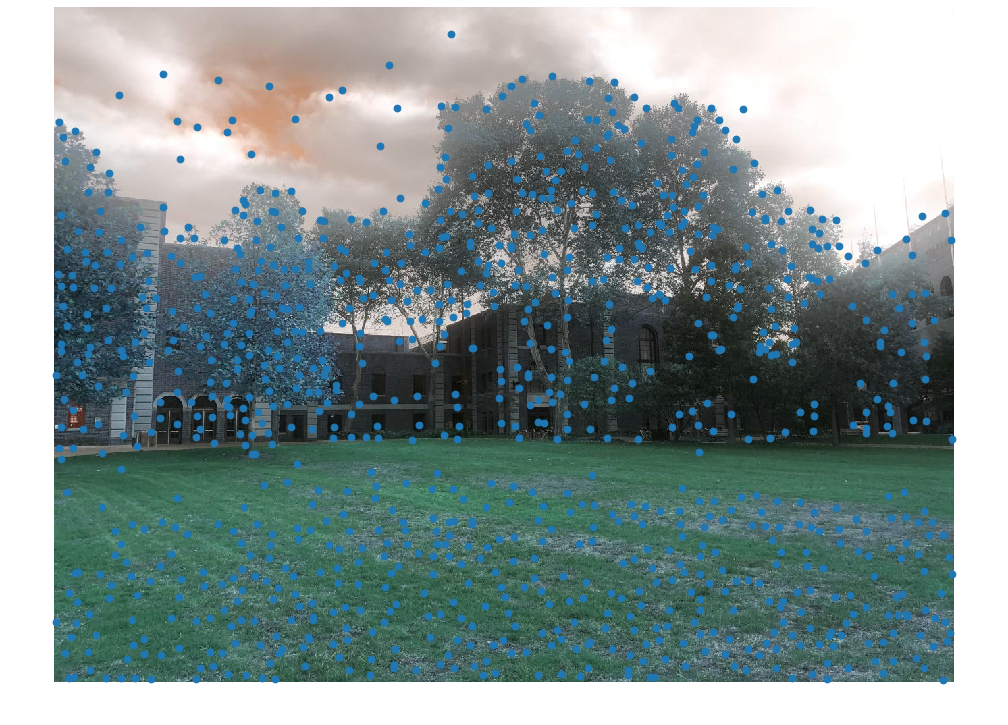

In [76]:
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.scatter(x, y)
plt.axis('off')

In [44]:
d = feat_desc(gray,x,y)

In [46]:
for i in d:
    print(i)

[ 27.  41.  38.  26.  28.  32.  29.  23.  90.  41.  41.  27.  36.  30.
  36.  30.  90.  17.  96.  36.  61.  38.  51.  36.  43.  31. 102.  34.
  47.  56.  52.  43.  36.  49.  50.  35.  41.  48.  49.  35.  65.  65.
  62.  43.  54.  45.  50.  40.  53.  33. 100.  53.  69.  23.  40.  17.
  29.  23.  69.  25.  34.  14.  21.  11.  70.  47.  49.  50.  69.  31.
  39.  36.  75.  58.  68.  41.  77.  43.  73.  41.  51.  29.  63.  41.
  65.  24.  71.  23.  34.  19.  50.  23.  44.  16.  57.  13.  48.  12.
  14.  14.  41.  18.  40.  19.  50.  16.  49.  15.  41.  16.  67.  17.
  32.  12.  32.  13.  41.  14.  75.  11.  18.   9.  24.  12.  21.  11.
  62.  11.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 28.  43.  59.  42.  25.  37.  68.  39.  32.  58.  98.  53.  30.  52.
  96.  49.  33.  58.  98.  56.  32.  54.  95.  48.  23.  42.  68.  39.
  25.  42.  69.  33.  40.  57.  70.  49.  34.  48.  85.  54.  40.  65.
  91.  61.  45.  72. 101.  55.  40.  74. 101.  56.  38.  74. 102.  54.
  33.  54.  81.  54.  32.  57.  84.  45.  19.  28.  39.  24.  19.  25.
  39.  27.  24.  40.  49.  35.  31.  34.  37.  24.  24.  41.  59.  37.
  21.  32.  40.  28.  19.  28.  38.  30.  19.  29.  33.  19.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 32. 28.]
[ 50.  66. 106. 100. 107.  86. 107.  79.  77.  91. 107. 100.  88.  94.
 107.  99.  81.  95. 107. 107.  68.  80. 103.  99.  63.  82. 100. 102.
  77.  66.  87.  74.   1.   0.   1.   1.   2.   1.   1.   2.   1.   1.
   3.   3.   2.   0.   1.   2.   2.   2.   4.   4.   1.   1.   1.   2.
   2.   2.   2.   2.   2.   1.   1.   2.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[ 53.  61. 101.  92.  49.  73. 107.  75.  63.  87. 107. 102.  62.  85.
 107. 107.  38.  63. 107.  98.  64.  84. 107.  82.  27.  39.  57.  54.
  40.  40.  58.  37.  31.  30.  48.  53.  28.  36.  72.  46.  45.  49.
  65.  60.  39.  47.  81.  64.  27.  35.  76.  61.  54.  47.  69.  51.
  18.  22.  32.  27.  32.  26.  30.  25.   0.   0.   0.

   0.   0.]
[  0.   0.   0.   0.   1.   1.   0.   0.   1.   1.   2.   2.   0.   0.
   0.   0.   0.   0.   1.   2.   1.   0.   0.   0.   0.   0.   1.   0.
   1.   0.   0.   0.   3.   4.  48.  39.  13.   6.   2.   1.   4.  20.
 109.  45.   2.   0.   0.   0.   2.  11. 109.  55.   7.   0.   0.   0.
   7.  24.  72.  34.  16.   2.   1.   1.   2.   8.  52.  78.  36.  33.
  22.   6.   4.  12. 109.  78.  13.  21.  14.   5.  16.  22. 109.  55.
  23.  17.  34.  32.  19.  46. 109.  95.  62.  34.  23.  15.   5.  22.
  48.  51.  69.  85.  44.  13.  36.  24.  51.  44.  31.  59.  54.  51.
  70.  57.  75.  85.  82.  75. 109. 109.  25.  37.  78. 109. 109. 100.
  74.  42.]
[ 20.  39.  20.   4.   4.   5.   6.   9.  19.  36.  35.  17.  20.  11.
   4.   5.  35.  75.  31.  10.   8.  14.   2.   4.   2.  14.  29.  14.
  28.  77.  17.   2.  21.  22.  19.  15.  10.  16.  39.  25.  12.  20.
  21.  13.  20.  27.  38.  21.  13.  32.  77.  26.   6.  31.  55.  17.
   9.  52.  60.  17.   4.  23.  32.   4.  38. 108.  4

[ 51.  44.  35.  38.  58.  72.  58.  53.  51.  31.  36.  47.  52.  67.
  74.  63.  50.  48.  60.  60.  39.  40.  59.  54.  52.  64.  87.  52.
  45.  46.  59.  54. 106.  65.  53.  46. 106.  75.  47.  43. 105.  34.
  76. 106. 106.  51.  59.  64.  48.  26.  53.  86.  42.  23.  34.  38.
  35.  27.  43.  26.  37.  22.  17.  15.  48.  52.  61.  44.  52.  11.
   5.   6.  43.  21.  38.  54.  77.  13.   6.   7.  60.  19.  14.  13.
  34.  12.  12.  17.  38.  25.  21.  17.  39.  28.  23.  16.  20.   8.
  24.  10.  21.   9.  24.   7.  20.   9.  18.  10.  28.  11.  21.  10.
  39.  18.  16.  10.  25.  13.  16.  17.  32.  21.  22.  13.  28.  17.
  22.  16.]
[  1.   3.   9.  12.  16.  22.   6.   1.  19.  38.   6.   1.   3.   7.
   4.   2.  19.  68.  30.   7.   9.   7.   1.   2.  23.  28.  15.  11.
  18.  10.   1.   2.   6.   9.  17.  21.  25.  34.  32.  11.  45.  29.
  16.  11.  12.  22.  36.  25.  40.  59.  54.  23.  22.  21.  25.  30.
  29.  52.  43.  19.  21.  13.  10.  11.  27.  91.  66.  22.  18.

  29.  34.]
[ 18.  17.   6.   4.   6.   9.   9.   7.  27.  59.  32.   8.   8.   8.
   8.  12.  25.  44.  37.  18.  22.  12.   4.   5.  30.  67.  28.  10.
   9.  17.   2.   3.  19.  18.  18.  11.  10.  36.  55.  17.  29.  30.
  29.  23.  16.  23.  54.  35.  15.  26.  27.  14.  22.  30.  39.  23.
  11.  32.  76.  26.   5.  26.  48.  13.  45. 112. 111.  66.  40.  29.
  40.  13.  45. 112.  61.  11.   9.  28.  96.  54.  12.  26.  34.  13.
  19.  56.  91.  36.  37.  19.   8.   7.  13.  52.  99.  55.  66.  80.
 101.  43.  52.  20.  14.  14. 109. 112. 112.  17.  23.  17.  23.  11.
  23. 112. 112.   7.   5.   7.  13.   6.  24.  92. 100.  53.  28.  17.
  16.  17.]
[  9.  12.  23.  20.   8.  13.  36.  22.  18.  24.  37.  27.  17.  27.
  60.  40.  21.  26.  41.  33.  20.  33.  69.  39.  14.  20.  23.  18.
  13.  23.  38.  23.  22.  32.  62.  37.  21.  41.  73.  45.  33.  50.
  94.  57.  27.  48. 101.  64.  26.  40.  70.  54.  32.  41.  70.  49.
  20.  27.  44.  33.  21.  24.  43.  34.  28.  43.  8

  65.  28.]
[ 48.  70. 108. 108. 107.  99. 108.  86.  67.  87. 108.  96.  93.  92.
 108.  90.  76.  91. 108. 103.  62.  84. 108. 100.  58.  75.  98.  89.
  64.  61.  81.  65.   8.   9.  19.  16.  19.  13.  14.  15.  11.  13.
  21.  16.  15.  11.  14.  15.  12.  14.  22.  21.  10.  11.  13.  13.
  10.  12.  14.  15.  12.   9.  12.  11.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[13. 22. 38. 22. 13. 24. 40. 20. 16. 34. 46. 24. 18. 36. 53. 22. 12. 31.
 47. 20. 13. 34. 56. 20.  9. 22. 34. 13.  9. 23. 40. 14. 24. 34. 50. 34.
 22. 41. 60. 32. 26. 53. 66. 38. 26. 53. 78. 36. 32. 53. 67. 41. 27. 52.
 80. 44. 24. 35. 52. 33. 24. 45. 65. 29. 26. 46. 72. 42. 29. 52. 72. 34.
 31. 54. 79. 41. 30. 57. 70. 41. 35. 63. 78. 

[ 79.  51.  66.  89. 103.  19.   9.  11.  58.  21.  26.  36.  59.  13.
   9.  16.  88.  41.  33.  25.  65.  36.  35.  27.  53.  34.  31.  25.
  46.  40.  36.  28.  45.  17.  36.  24.  65.  22.  37.  16.  64.  27.
  36.  17.  44.  24.  37.  31. 103.  59.  53.  36.  83.  43.  54.  44.
  50.  43.  51.  35.  49.  45.  48.  33.  42.  18.  38.  20.  55.  34.
  94.  28.  55.  25.  31.  18.  47.  36.  93.  40.  86.  43.  47.  27.
  86.  43.  80.  50.  65.  36.  50.  33.  67.  43.  59.  40.   7.  13.
  26.  11.   9.  27.  67.  17.   8.  16.  27.  13.   9.  31.  91.  23.
  11.  14.  24.  16.  13.  34.  77.  25.  11.  12.  21.  11.  11.  30.
  63.  18.]
[ 41.  28.  42.  34.  37.  43.  49.  36.  52.  46.  52.  43.  49.  66.
  68.  52.  57.  44.  42.  52.  55.  62.  65.  69.  48.  45.  35.  34.
  47.  62.  57.  49.  67.  14.  82.  31.  50.  35.  47.  33.  66.  45.
 105.  48.  70.  79.  72.  62.  79.  42. 105.  50.  71.  56.  67.  81.
  71.  57.  73.  30.  65.  65.  45.  36.  34.  20.  70.  34.  45.

 46. 44.]
[ 14.  45.  35.  19.   9.  17.  27.   9.   8.  29.  13.   5.   4.  15.
  51.  25.   7.   4.   4.   4.   9.  27.  40.  21.  10.   7.   9.   5.
   6.  33.  60.  18.  58.  74.  63.  30.  33.  12.   9.   8.  52. 106.
 108.   8.   9.  11.  16.   9.  12.  71.  72.   6.   4.  11.  19.  11.
  23.  46.  50.  37.  22.  19.  18.  20.  59.  59.  90.  34.  33.  25.
  30.  23.  87.  90. 108.  21.  47.  14.  54.  20.  27.  86. 108.  15.
   8.   9.  18.   8.  26.  87. 108.  78.  45.  29.  22.  15.  70.  63.
  63.  39.  43.  35.  43.  44.  54.  63.  82.  41.  87.  22.  54.  43.
  38.  62.  98.  43.  31.  29.  30.  32.  38.  50.  57.  42.  30.  22.
  18.  20.]
[ 28.  52.  80.  52.  30.  48.  81.  42.  29.  56.  91.  50.  32.  64.
  91.  41.  30.  53.  71.  35.  25.  51.  70.  38.  24.  48.  60.  30.
  20.  42.  71.  33.  38.  60.  83.  60.  36.  63.  89.  51.  41.  84.
 104.  73.  49.  79. 104.  54.  50.  90.  92.  53.  44.  76. 104.  55.
  33.  72.  85.  43.  34.  65.  89.  41.  14.  23.  30.

  27.  10.]
[ 35.  34.  32.  34.  34.  24.  22.  25.  34.  44.  46.  34.  26.  27.
  28.  27.  28.  40.  50.  32.  25.  26.  24.  23.  38.  29.  51.  36.
  31.  27.  27.  22.  42.  45.  46.  39.  41.  40.  41.  36.  49.  69.
  63.  38.  44.  59.  49.  37.  45.  63.  61.  43.  42.  45.  44.  37.
 103.  28.  38.  28.  48.  41.  48.  37.  41.  51.  55.  44.  42.  53.
  56.  47.  49.  64.  63.  43.  52.  69.  61.  45.  49.  65.  58.  41.
  46.  52.  58.  43.  88.  43.  74.  37.  60.  28.  30.  24.  47.  38.
  43.  43.  60.  41.  49.  39.  50.  56.  54.  47.  57.  43.  43.  36.
  53.  53.  53.  43.  49.  39.  47.  39.  31.  33.  38.  34.  48.  27.
  44.  24.]
[18. 41. 56. 46. 28. 18. 14. 11. 70. 74. 67. 63. 52. 36. 40. 49. 54. 71.
 67. 69. 57. 29. 29. 27. 33. 43. 39. 10.  6.  7. 11. 14. 35. 39. 39. 33.
 24. 18. 14. 17. 64. 74. 65. 61. 46. 33. 37. 38. 64. 64. 66. 61. 45. 38.
 44. 48. 43. 50. 64. 34. 20. 19. 21. 32. 51. 51. 43. 44. 43. 35. 30. 36.
 60. 68. 63. 61. 59. 42. 41. 44. 51. 66. 74. 

  46.  18.]
[ 11.  12.  14.   9.   8.   9.  16.  12.  10.  20.  17.   7.  10.  10.
  12.   8.   7.  28.  57.  21.   3.  10.  15.   3.   7.  31.  31.   8.
   4.  13.   9.   3.  12.  42.  20.   5.   4.  15.  53.  28.   9.   8.
   8.   6.  12.  38.  57.  28.  22.  11.  11.   6.  11.  55. 101.  37.
   7.  23.  12.   6.  21.  54.  61.  13.  52.  93. 106.   8.   9.   9.
  13.   7.  13.  85.  87.   7.   4.  10.  16.   9.  31.  74.  79.  56.
  31.  23.  20.  23.  51.  86. 106.  91.  61.  59.  59.  43.  59.  59.
  96.  16.  36.  11.  42.  16.  27.  72. 106.  15.  11.   9.  17.   9.
  28.  94. 106.  82.  46.  30.  25.  16.  90.  94.  92.  92.  75.  52.
  53.  65.]
[ 29.  41.  40.  26.  33.  38.  36.  26.  72.  50.  44.  29.  34.  32.
  37.  33.  95.  23. 104.  36.  77.  22.  25.  20.  24.  21. 104.  26.
  31.  29.  29.  22.  41.  55.  56.  44.  47.  49.  50.  39.  56.  70.
  62.  47.  57.  53.  60.  46.  50.  44.  71.  66.  67.  33.  74.  28.
  36.  24.  34.  28.  41.  17.  40.  15.  84.  36.  4

  24.  23.]
[ 22.  15.  60.  17.  21.  13.  52.   8.  51.  22.  45.  33.  73.  25.
  39.  17.  57.  23.  32.  16.  41.  21.  32.  26.  81.  42.  36.  26.
  60.  30.  36.  31.  24.  13.  75.  16.  26.  31. 108.  20.  73.  28.
  61.  31.  91.  48. 108.  40.  64.  30.  43.  21.  58.  40.  98.  45.
  86.  43.  41.  24.  80.  37.  67.  46.   8.  21.  40.  14.  12.  42.
 108.  21.  15.  24.  47.  22.  20.  54. 108.  34.  15.  22.  36.  18.
  16.  47. 108.  36.  19.  17.  28.  19.  20.  41.  93.  33.  13.  29.
  52.  24.  16.  40.  65.  23.  16.  33.  53.  23.  18.  41.  68.  24.
  14.  39.  56.  20.  15.  41.  69.  26.   9.  26.  46.  17.  10.  32.
  58.  16.]
[ 25.  33.  41.  24.  15.  14.  15.  19.  18.  30.  71.  36.  23.  22.
  19.  11.  12.  27.  51.  46.  33.  27.  20.  13.  11.  15.  37.  31.
  17.  15.  16.  14.  24.  33.  42.  28.  25.  25.  24.  22.  77.  41.
  60.  49.  52.  49.  51.  42.  55.  50.  78.  58.  59.  80.  91.  65.
  60.  50.  49.  51.  57.  71.  70.  60.  32.  46.  4

[ 67.  69. 106. 112.  60.  86. 115.  98.  93. 110. 115. 115.  85. 104.
 115. 115.  49.  71. 115. 115. 106.  99. 115.  93.  38.  49.  65.  56.
  60.  53.  66.  51.   6.   5.   7.   8.   5.   5.  12.   8.   8.   8.
  12.  14.   8.   8.  11.  10.   5.   6.  12.  10.  11.   8.   9.  10.
   4.   4.   8.   6.   6.   4.   5.   6.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[21. 31. 54. 31. 20. 36. 57. 28. 23. 39. 53. 34. 23. 44. 57. 29. 23. 42.
 56. 31. 21. 42. 58. 31. 23. 33. 46. 27. 16. 33. 50. 27. 30. 56. 87. 53.
 31. 53. 93. 46. 29. 58. 93. 52. 34. 67. 90. 42. 34. 64. 80. 36. 26. 54.
 87. 45. 25. 53. 69. 38. 24. 48. 78. 35. 31. 49. 70. 50. 31. 51. 68. 38.
 37. 71. 86. 56. 41. 63. 97. 45. 42. 75. 76. 43. 38. 66. 